In [30]:
import cv2
import numpy as np
import os
import pandas as pd
# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# miscellaneous
import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# deep learning stack
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

In [31]:
image_test = cv2.imread('data/banana.png')

In [32]:
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

sharpening_kernel = np.array([[-1, -1, -1, -1, -1],
                              [-1,  2,  2,  2, -1],
                              [-1,  2,  3,  2, -1],
                              [-1,  2,  2,  2, -1],
                              [-1, -1, -1, -1, -1]])


In [33]:
filtered_image = cv2.filter2D(image_test, -1, kernel)
grayscale_image = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)
grayscale_image = cv2.filter2D(grayscale_image , -1, sharpening_kernel)

In [34]:
cv2.imshow('Original Image', image_test)
cv2.imshow('Filtered Image', filtered_image)
cv2.imshow('Greyscale Image', grayscale_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### STEP BY STEP

In [143]:

directory = 'data/train/'
X = []
labels_array = []
images = []
labels = {0: 'bananas', 1: 'cellphones', 2: 'spectacles', 3: 'cups'}


In [144]:
for id, label in labels.items():
    directory_ = directory + label
    file_list = os.listdir(directory_)

    for filename in file_list:

        if filename.endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(directory_, filename)
            image_test = cv2.imread(file_path)
            

            if image_test is not None:

                # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                
                images.append(image)
                labels_array.append(id)

images_array = np.array(images)
labels_array = np.array(labels_array)

print("Shape images array:", images_array.shape)

Shape images array: (400,)


In [ ]:
shuffler = np.random.permutation(len(images_array))
X = images_array[shuffler]
y = labels_array[shuffler]


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2,
    preprocess_input as ppi_v2,
    decode_predictions
)

# vgg16
from tensorflow.keras.applications.vgg16 import (
    VGG16,
    preprocess_input as ppi_vgg16,
    decode_predictions
)

pretrained_model_V2 = MobileNetV2(
    weights='imagenet'
)

pretrained_model_vgg16 = VGG16(
    include_top=True,
    weights='imagenet',
    classes=1000
)

In [ ]:
pretrained_model_V2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
pretrained_model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def load_image(image_path):
    """
    loads an input image into PIL format of size 224 X 224
    """
    img = image.load_img(
        path=image_path,
        target_size=(224,224)
    )
    return img

def batch_image(loaded_image):
    """
    converts a loaded image to a batch
    """
    img_array = image.img_to_array(loaded_image)
    img_batch = np.array([img_array])
    
    return img_batch

def preprocess_image_v2(batched_image):
    """
    preprocesses a batch image to make suitable for mobilenet_v2
    """
    processed_img = ppi_v2(batched_image)
    
    return processed_img

def preprocess_image_vgg16(batched_image):
    """
    preprocesses a batch image to make suitable for mobilenet_v2
    """
    processed_img = ppi_vgg16(batched_image)
    
    return processed_img


def show_preprocess_image(image_path, tp):
    """
    shows loaded image given an image path, and
    preprocesses it to make suitable for mobilenet_v2
    """
    # load resized image
    loaded_img = load_image(image_path)
    
    # display image
    plt.figure(figsize=(3,3), dpi=100)
    plt.imshow(loaded_img)
    
    # create batched image
    batch_img = batch_image(loaded_img)
    
    # preprocess image
    processed_img = preprocess_image_v2(batch_img) if tp == 2 else preprocess_image_vgg16(batch_img) 
    
    return processed_img





In [ ]:
def image_class_prediction(model, preprocessed_image):
    """
    spits out the top-5 predictions of a given model with a proprocessed image
    """
    model_prediction = model.predict(preprocessed_image,verbose=0)
    decoded_prediction = decode_predictions(model_prediction,top=5)[0]
    data = {
        'image_class': [_[1] for _ in decoded_prediction],
        'probability': [_[2] for _ in decoded_prediction]
    }
    df = pd.DataFrame(data=data)
    return df

In [ ]:
CLASSES = os.listdir('data/train/')
CLASSES

['bananas', 'cellphones', 'cups', 'spectacles']

In [37]:
data_gen_v2 = image.ImageDataGenerator(
    # preprocessing function for all images
    preprocessing_function = ppi_v2
)

In [38]:
data_gen_vgg16 = image.ImageDataGenerator(
    # preprocessing function for all images
    preprocessing_function=ppi_vgg16
)

In [40]:
train_data_gen_vgg16 = data_gen_vgg16.flow_from_directory(
        directory='data/train',
        class_mode="categorical",
        classes=CLASSES,
        batch_size=300,
        target_size=(224,224)
)

Found 400 images belonging to 4 classes.


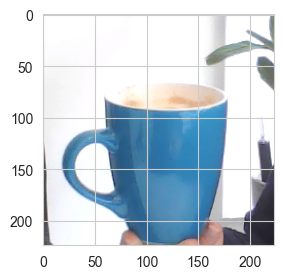

In [42]:
test_image = show_preprocess_image(
    'data/train/cups/10-54-57-244120.png', 16
)

In [43]:
# class prediction

image_class_prediction(
    pretrained_model_V2,
    test_image
)

,image_class,probability
0,breastplate,0.084176
1,lampshade,0.084053
2,loudspeaker,0.071717
3,spotlight,0.045628
4,fire_screen,0.040886


In [44]:
# class prediction

image_class_prediction(
    pretrained_model_vgg16,
    test_image
)

,image_class,probability
0,coffee_mug,0.569125
1,cup,0.151476
2,espresso,0.105648
3,espresso_maker,0.042483
4,coffeepot,0.035065


In [48]:
train_data_gen_v2 = data_gen_v2.flow_from_directory(
        directory='data/train',
        class_mode="categorical",
        classes=CLASSES,
        batch_size=300,
        target_size=(224,224)
)

Found 400 images belonging to 4 classes.


In [49]:
test_data_gen_v2 = data_gen_v2.flow_from_directory(
        directory='data/test',
        class_mode="categorical",
        classes=CLASSES,
        batch_size=300,
        target_size=(224,224)
)

Found 40 images belonging to 4 classes.


In [50]:
xtrain, ytrain = next(train_data_gen_v2)
xtest, ytest = next(test_data_gen_v2)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape, 

((300, 224, 224, 3), (300, 4), (40, 224, 224, 3), (40, 4))

In [58]:
BASE_MODEL_V2 = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,          # controls number of overall weights
    include_top=False,  # removal of final dense layers
    pooling='avg',      # average pooling to last convolutional layer's ouput
    input_shape=(224,224,3) # ignored if input tensor is provided
)

In [60]:
BASE_MODEL_VGG16 = VGG16(
    weights='imagenet', 
    include_top=False,  # removal of final dense layers
    pooling='avg',      # average pooling to last convolutional layer's ouput
    input_shape=(224,224,3) # ignored if input tensor is provided
)

In [61]:
BASE_MODEL_V2.trainable = False
BASE_MODEL_VGG16.trainable = False

In [62]:
BASE_MODEL_V2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [63]:
BASE_MODEL_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [64]:
def BuildModel():
    '''
    complies a model by stacking dense layers on top of base model 
    '''
    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(BASE_MODEL_V2)
    
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=160, 
            activation='relu'
        )
    )
    # dropout 
    model.add(
        keras.layers.Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )

    return model

In [65]:
model = BuildModel()

In [66]:
stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10
)

In [67]:
model.fit(
    xtrain,
    ytrain,
    epochs=100,
    batch_size=20,
    callbacks=[stop_early],
    validation_split=0.2
)

Epoch 1/100
12/12 [==============================] - 6s 383ms/step - loss: 0.8240 - categorical_accuracy: 0.7083 - val_loss: 0.2038 - val_categorical_accuracy: 0.9500
Epoch 2/100
12/12 [==============================] - 4s 316ms/step - loss: 0.1597 - categorical_accuracy: 0.9583 - val_loss: 0.1804 - val_categorical_accuracy: 0.9167
Epoch 3/100
12/12 [==============================] - 4s 322ms/step - loss: 0.0839 - categorical_accuracy: 0.9792 - val_loss: 0.1082 - val_categorical_accuracy: 0.9667
Epoch 4/100
12/12 [==============================] - 4s 318ms/step - loss: 0.0534 - categorical_accuracy: 0.9792 - val_loss: 0.1176 - val_categorical_accuracy: 0.9500
Epoch 5/100
12/12 [==============================] - 4s 318ms/step - loss: 0.0217 - categorical_accuracy: 0.9958 - val_loss: 0.1149 - val_categorical_accuracy: 0.9667
Epoch 6/100
12/12 [==============================] - 4s 328ms/step - loss: 0.0160 - categorical_accuracy: 1.0000 - val_loss: 0.0946 - val_categorical_accuracy: 0.983

In [68]:
# losses in the training history
losses = pd.DataFrame(model.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

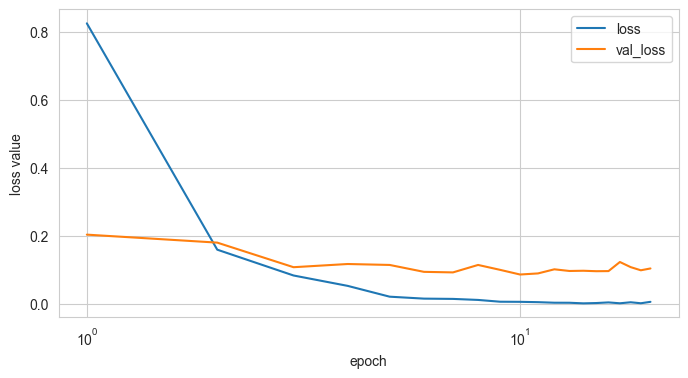

In [69]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,4),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=10)
plt.ylabel('loss value',fontsize=10)
plt.legend(loc=1,fontsize=10)

In [70]:
def image_predict(preprocessed_image, model):
    """
    returns class probabilities for a given image,
    based on the model obtained via transfer learning 
    """
    probabilities = model.predict(
        preprocessed_image,
        verbose=0
    )
    probabilities = np.round(probabilities,6)[0]
    class_probabilities = dict(zip(CLASSES,probabilities))
    
    return class_probabilities

In [71]:
image_predict(test_image, model)

{'bananas': 0.005674,
 'cellphones': 0.01017,
 'cups': 0.979183,
 'spectacles': 0.004974}

In [74]:
def transfer_learning_prediction(model, x, y):
    """
    returns dataframe with class probabilities and true class label 
    """
    # prediction dataframe along with true class
    df_pred = pd.DataFrame(
        columns=CLASSES,
        data=np.round(model.predict(x,verbose=0),6)
    )
    # convert vectorized classes into strings
    df_pred['class'] = \
    [''.join([i*j for (i,j) in zip(CLASSES,vector)]) for vector in y.astype(int)]
    
    return df_pred

In [75]:
def accuracy_score(model,x,y):
    """
    This function spits out multi-class accuracy
    """
    grouped_df = transfer_learning_prediction(
        model, x, y
    ).groupby('class').sum()
    
    grouped_df.sort_index(axis=1,inplace=True)
    
    accuracy_score = np.trace(grouped_df)/np.array(grouped_df).sum()
    accuracy_score = round(accuracy_score,6)
    
    return accuracy_score

In [76]:
test_prediction = transfer_learning_prediction(
    model,
    xtest,
    ytest
)

test_prediction

,bananas,cellphones,cups,spectacles,class
0,0.998968,0.000040,0.000882,0.000110,bananas
1,0.002928,0.579619,0.084564,0.332888,spectacles
2,0.000014,0.000003,0.999972,0.000010,cups
3,0.000001,0.000000,0.999998,0.000001,cups
4,0.000217,0.000486,0.002176,0.997122,spectacles
5,0.000814,0.857279,0.072038,0.069869,cellphones
6,0.008025,0.674172,0.002816,0.314987,cellphones
7,0.000033,0.000019,0.000147,0.999802,spectacles
8,0.000035,0.000056,0.001819,0.998090,spectacles
9,0.004732,0.004515,0.986991,0.003762,cups


In [79]:
accuracy_score(model, xtest, ytest)

0.919019

In [78]:
accuracy_score(model, xtrain, ytrain)

0.992713

In [112]:
def HyperModel(hyperparameters):
    '''
    creates a hypermodel by stacking dense layers on top of base model. 
    Two hyperparameters to be tuned: 
    1. number of neurons in the first dense layer,
    2. initial learning rate of the optimizer
    Args:
    hyperparameters - Keras tuner object
    '''
    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(BASE_MODEL_V2)
    
    # number of neurons in first dense layer
    hp_units = hyperparameters.Choice(
        'units', 
        values=[320,160,80]
    )
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=hp_units, 
            activation='relu'
        )
    )
    # dropout 
    model.add(
        keras.layers.Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    # learning rate for the optimizer
    hp_learning_rate = hyperparameters.Choice(
        'learning_rate', 
        values=[1e-2, 1e-3, 1e-4]
    )
    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp_learning_rate
        ),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )

    return model

In [114]:
def HyperModel_VGG16(hyperparameters):
    '''
    creates a hypermodel by stacking dense layers on top of base model. 
    Two hyperparameters to be tuned: 
    1. number of neurons in the first dense layer,
    2. initial learning rate of the optimizer
    Args:
    hyperparameters - Keras tuner object
    '''
    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(BASE_MODEL_VGG16)
    
    # number of neurons in first dense layer
    hp_units = hyperparameters.Choice(
        'units', 
        values=[320,160,80]
    )
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=hp_units, 
            activation='relu'
        )
    )
    # dropout 
    model.add(
        keras.layers.Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    # learning rate for the optimizer
    hp_learning_rate = hyperparameters.Choice(
        'learning_rate', 
        values=[1e-2, 1e-3, 1e-4]
    )
    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp_learning_rate
        ),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )

    return model

In [88]:
import keras_tuner as kt

In [115]:
tuner_v2 = kt.GridSearch(
    hypermodel=HyperModel_VGG16,
    objective='val_categorical_accuracy'
)

tuner_vgg16 = kt.GridSearch(
    hypermodel=HyperModel_VGG16,
    objective='val_categorical_accuracy'
)

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [116]:
tuner_v2.search_space_summary() 

Search space summary
Default search space size: 2
units (Choice)
{'default': 320, 'conditions': [], 'values': [320, 160, 80], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [117]:
tuner_vgg16.search_space_summary() 

Search space summary
Default search space size: 2
units (Choice)
{'default': 320, 'conditions': [], 'values': [320, 160, 80], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [118]:
stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15
)

In [94]:
tuner_v2.search(
    xtrain, 
    ytrain,
    epochs=20,
    validation_split=0.2,
    callbacks=[stop_early]
)

Trial 9 Complete [00h 01m 33s]
val_categorical_accuracy: 0.9666666388511658

Best val_categorical_accuracy So Far: 0.9833333492279053
Total elapsed time: 00h 12m 48s
INFO:tensorflow:Oracle triggered exit


In [120]:
tuner_vgg16.search(
    xtrain, 
    ytrain,
    epochs=20,
    validation_split=0.2,
    callbacks=[stop_early]
)

INFO:tensorflow:Oracle triggered exit


In [122]:
best_hp = tuner_v2.get_best_hyperparameters(1)[0]

In [123]:
best_hp.get('units')

320

In [124]:
best_hp.get('learning_rate')

0.01

In [125]:
h_model = tuner_v2.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_4 (Dense)             (None, 320)               164160    
                                                                 
 dropout_2 (Dropout)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1284      
                                                                 
Total params: 14,880,132
Trainable params: 165,444
Non-trainable params: 14,714,688
_________________________________________________________________


In [126]:
h_model.fit(
    xtrain,
    ytrain,
    epochs=100,
    batch_size=10,
    callbacks=[stop_early],
    validation_split=0.2
)

Epoch 1/100
24/24 [==============================] - 24s 978ms/step - loss: 1.4876 - categorical_accuracy: 0.4792 - val_loss: 0.9332 - val_categorical_accuracy: 0.5333
Epoch 2/100
24/24 [==============================] - 22s 929ms/step - loss: 0.6372 - categorical_accuracy: 0.7583 - val_loss: 0.5998 - val_categorical_accuracy: 0.7667
Epoch 3/100
24/24 [==============================] - 23s 962ms/step - loss: 0.3856 - categorical_accuracy: 0.8458 - val_loss: 0.3200 - val_categorical_accuracy: 0.8833
Epoch 4/100
24/24 [==============================] - 23s 959ms/step - loss: 0.3368 - categorical_accuracy: 0.8792 - val_loss: 0.2243 - val_categorical_accuracy: 0.9167
Epoch 5/100
24/24 [==============================] - 22s 939ms/step - loss: 0.2819 - categorical_accuracy: 0.9042 - val_loss: 0.2260 - val_categorical_accuracy: 0.9000
Epoch 6/100
24/24 [==============================] - 23s 972ms/step - loss: 0.3118 - categorical_accuracy: 0.8917 - val_loss: 0.2538 - val_categorical_accuracy:

In [127]:
losses = pd.DataFrame(h_model.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

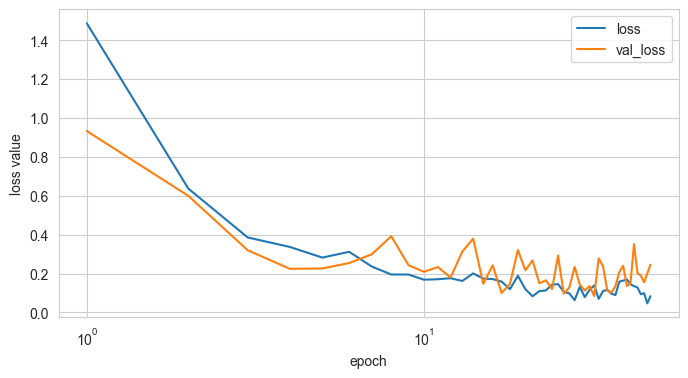

In [128]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,4),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=10)
plt.ylabel('loss value',fontsize=10)
plt.legend(loc=1,fontsize=10)

In [129]:
test_prediction = transfer_learning_prediction(
    h_model,
    xtest,
    ytest
)

test_prediction.head()

,bananas,cellphones,cups,spectacles,class
0,0.854141,0.000226,0.145504,0.000129,bananas
1,0.006113,0.000004,0.000183,0.993701,spectacles
2,0.000000,0.000000,1.000000,0.000000,cups
3,0.000000,0.000000,1.000000,0.000000,cups
4,0.002154,0.495962,0.001961,0.499923,spectacles


In [130]:
accuracy_score(h_model, xtest, ytest)

0.827535

In [131]:
best_hp_vgg16 = tuner_vgg16.get_best_hyperparameters(1)[0]
h_model_vgg16 = tuner_v2.hypermodel.build(best_hp)
h_model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_6 (Dense)             (None, 320)               164160    
                                                                 
 dropout_3 (Dropout)         (None, 320)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1284      
                                                                 
Total params: 14,880,132
Trainable params: 165,444
Non-trainable params: 14,714,688
_________________________________________________________________


In [132]:
h_model_vgg16.fit(
    xtrain,
    ytrain,
    epochs=100,
    batch_size=20,
    callbacks=[stop_early],
    validation_split=0.2
)

Epoch 1/100
12/12 [==============================] - 20s 2s/step - loss: 1.7711 - categorical_accuracy: 0.4333 - val_loss: 0.9489 - val_categorical_accuracy: 0.6833
Epoch 2/100
12/12 [==============================] - 19s 2s/step - loss: 0.8044 - categorical_accuracy: 0.6833 - val_loss: 0.7144 - val_categorical_accuracy: 0.7500
Epoch 3/100
12/12 [==============================] - 20s 2s/step - loss: 0.5209 - categorical_accuracy: 0.8125 - val_loss: 0.4007 - val_categorical_accuracy: 0.8333
Epoch 4/100
12/12 [==============================] - 19s 2s/step - loss: 0.3832 - categorical_accuracy: 0.8625 - val_loss: 0.3337 - val_categorical_accuracy: 0.8500
Epoch 5/100
12/12 [==============================] - 19s 2s/step - loss: 0.3058 - categorical_accuracy: 0.8875 - val_loss: 0.2762 - val_categorical_accuracy: 0.8667
Epoch 6/100
12/12 [==============================] - 19s 2s/step - loss: 0.2039 - categorical_accuracy: 0.9333 - val_loss: 0.2201 - val_categorical_accuracy: 0.9000
Epoch 7/10

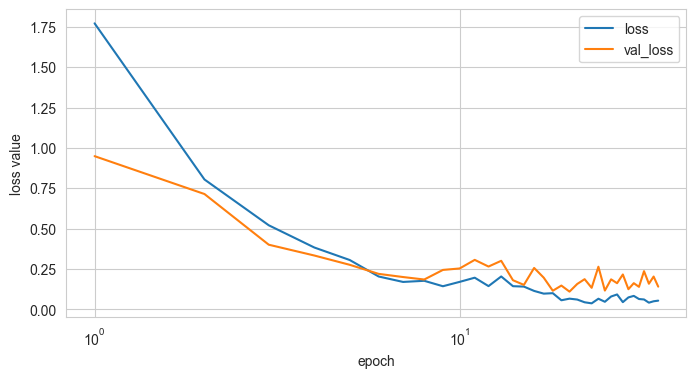

In [133]:
losses = pd.DataFrame(h_model_vgg16.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

# plot losses against epoch number in log-scale
plt.figure(figsize=(8,4),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=10)
plt.ylabel('loss value',fontsize=10)
plt.legend(loc=1,fontsize=10)

In [136]:
test_prediction = transfer_learning_prediction(
    h_model_vgg16,
    xtest,
    ytest
)

test_prediction.head()

,bananas,cellphones,cups,spectacles,class
0,0.039218,0.000134,0.960643,0.000006,bananas
1,0.332288,0.000004,0.000009,0.667699,spectacles
2,0.000000,0.000000,1.000000,0.000000,cups
3,0.000000,0.000000,1.000000,0.000000,cups
4,0.002034,0.965814,0.000113,0.032039,spectacles


In [138]:
accuracy_score(h_model_vgg16, xtest, ytest)

0.768661

In [140]:
# serialize model
h_model_vgg16.save("data/model_vgg16.h5")
print("Saved model model_vgg16.h5 to disk")

Saved model model_vgg16.h5 to disk


In [141]:
h_model.save("data/model_v2.h5")
print("Saved model v2 to disk")

Saved model v2 to disk
